# **Elo Merchant Category Recommendation**



---



# Table of Contents


>*   [6. First Cut Solution](#section6)
  *   [6.1. Splitting Features and Labels](#section6.1)
  *   [6.2. Train Validation Split](#section6.2)
  *   [6.2. Base Line Model](#section6.3)
  *   [6.4. Model Building](#section6.4)
      *   [6.4.1. Linear regression](#section6.4.1)
      *   [6.4.2. SVR Model](#section6.4.2)
      *   [6.4.3. Random Forest Regressor](#section6.4.3)
      *   [6.4.4. LGBM Regressor](#section6.4.4)
      *   [6.4.5. AutoEncoder Model](#section6.4.5)
  *   [6.5. Summary](#section6.5)
  *   [6.6. Final Submission](#section6.6)








---



# Importing Libraries

In [48]:
# importing the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import datetime
import datetime as dt
from pandas import DataFrame
from math import sqrt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.datasets import make_regression
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
from lightgbm import LGBMRegressor
from prettytable import PrettyTable
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, ReLU, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model
from keras import backend as K
from keras.callbacks import EarlyStopping
import pickle

# Loading Datasets

In [49]:
#ref: https://www.kaggle.com/fabiendaniel/elo-world
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [50]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Case Study 1/Data/Dataset/'
model_path = '/content/drive/MyDrive/Colab Notebooks/Case Study 1/Data/Model/'
result_path = '/content/drive/MyDrive/Colab Notebooks/Case Study 1/Data/Result/'

In [51]:
train = pd.read_csv(dataset_path + 'train_FE1.csv')
test = pd.read_csv(dataset_path + 'test_FE1.csv')

print('Shape of train data =', train.shape)
print('Shape of test data =', test.shape)

Shape of train data = (201917, 32)
Shape of test data = (123623, 31)


In [52]:
# reduce the memory of all datasets
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 15.21 Mb (69.1% reduction)
Mem. usage decreased to  8.61 Mb (70.6% reduction)


In [53]:
train.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,old_purchase_amount_count,old_purchase_amount_sum,old_purchase_amount_mean,old_purchase_amount_std,old_purchase_amount_min,old_purchase_amount_max,old_installments_count,old_installments_sum,old_installments_mean,old_installments_std,old_installments_min,old_installments_max,new_purchase_amount_count,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_std,new_purchase_amount_min,new_purchase_amount_max,new_installments_count,new_installments_sum,new_installments_mean,new_installments_std,new_installments_min,new_installments_max
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,6,2017,260,-165.968735,-0.638341,0.212139,-0.739258,2.258394,260,4,0.015381,0.123291,0,1,23.0,-13.242188,-0.575684,0.135742,-0.724609,-0.296143,23.0,0.0,0.0,0.0,0.0,0.0
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392822,1,2017,350,-210.006332,-0.600018,0.384967,-0.742188,4.630300,350,543,1.551758,1.510742,-1,10,6.0,-4.355469,-0.726074,0.014381,-0.739258,-0.701660,6.0,6.0,1.0,0.0,1.0,1.0


In [54]:
test.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,month,year,old_purchase_amount_count,old_purchase_amount_sum,old_purchase_amount_mean,old_purchase_amount_std,old_purchase_amount_min,old_purchase_amount_max,old_installments_count,old_installments_sum,old_installments_mean,old_installments_std,old_installments_min,old_installments_max,new_purchase_amount_count,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_std,new_purchase_amount_min,new_purchase_amount_max,new_installments_count,new_installments_sum,new_installments_mean,new_installments_std,new_installments_min,new_installments_max
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,4,2017,68,-40.733734,-0.599121,0.192261,-0.744141,0.235676,68,141,2.074219,2.060547,1,12,3.0,-1.777344,-0.592285,0.182861,-0.722168,-0.383301,3.0,5.0,1.666992,1.154297,1.0,3.0
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,1,2017,78,-49.136513,-0.629883,0.155029,-0.731934,0.318817,78,83,1.064453,0.405762,1,4,9.0,-5.945312,-0.660645,0.071167,-0.740723,-0.506348,9.0,11.0,1.222656,0.666504,1.0,3.0


<a name='section6'><a/>
# 6. First Cut Solution

<a name='section6.1'><a/>
## 6.1. Splitting features and labels

In [55]:
train_data_y = train['target'].values
train_data_x = train.drop(['card_id','first_active_month','target'], axis=1)

test_data_x = test.drop(['card_id','first_active_month'], axis=1)

print('Shape of final train data :', train_data_x.shape, train_data_y.shape)
print('Shape of final test data :', test_data_x.shape)

Shape of final train data : (201917, 29) (201917,)
Shape of final test data : (123623, 29)


<a name='section6.2'><a/>
## 6.2. Train Validation Split

In [81]:
# splitting data into train and validation set
x_train, x_val, y_train, y_val = train_test_split(train_data_x, train_data_y, test_size=0.25)
print('Shape of Train Data :', x_train.shape, y_train.shape)
print('Shape of Val Data :', x_val.shape, y_val.shape)

Shape of Train Data : (151437, 29) (151437,)
Shape of Val Data : (50480, 29) (50480,)


<a name='section6.3'><a/>
## 6.3. Base Line Model

In [58]:
n = y_train.shape[0]
default_value = np.mean(y_train)
y_pred = np.array([default_value for i in range(n)])
print("Base RMSE: {:4f}".format(sqrt(mean_squared_error(y_train, y_pred))))

Base RMSE: 3.856812


<a name='section6.4'><a/>
## 6.4. Model Building

<a name='section6.4.1'><a/>
### 6.4.1. Linear Regression

In [60]:
model1 = LinearRegression()
model1.fit(x_train, y_train)

filename = model_path + 'linear_regression.sav'
pickle.dump(model1, open(filename, 'wb'))

In [61]:
filename = model_path + 'linear_regression.sav'
model1 = pickle.load(open(filename, 'rb'))

y_pred_train = model1.predict(x_train)
y_pred_val = model1.predict(x_val)

train_rmse = sqrt(mean_squared_error(y_train, y_pred_train)) 
val_rmse = sqrt(mean_squared_error(y_val, y_pred_val))

print('Train RMSE: ', train_rmse)
print('Val RMSE: ', val_rmse)

Train RMSE:  3.8283317665780006
Val RMSE:  3.8708621666980365


In [63]:
df = pd.DataFrame({'card_id': test['card_id'].values})
test_data_y = model1.predict(test_data_x)
df['target'] = test_data_y
df.to_csv(result_path + 'linear_regression_test.csv', index=False)

<a name='section6.4.2'><a/>
### 6.4.2. SVR Model

In [91]:
model2 = SVR(kernel='rbf')
model2.fit(x_train, y_train)

filename = model_path + 'svr_model.sav'
pickle.dump(model2, open(filename, 'wb'))

In [92]:
filename = model_path + 'svr_model.sav'
model2 = pickle.load(open(filename, 'rb'))

y_pred_train = model2.predict(x_train)
y_pred_val = model2.predict(x_val)

train_rmse = sqrt(mean_squared_error(y_train, y_pred_train))
val_rmse = sqrt(mean_squared_error(y_val, y_pred_val))

print("Train RMSE: {:2.5f}".format(train_rmse))
print("Val RMSE: {:2.5f}".format(val_rmse))

Train RMSE: 3.88890
Val RMSE: 3.80095


In [93]:
df = pd.DataFrame({'card_id': test['card_id'].values})
test_data_y = model2.predict(test_data_x)
df['target'] = test_data_y
df.to_csv(result_path + 'svr_test.csv', index=False)

<a name='section6.4.3'><a/>
### 6.4.3. Random Forest Regressor

In [64]:
model4 = RandomForestRegressor(n_jobs=-1)
params = {'n_estimators': [10, 100, 250, 500],
          'max_depth': [1, 5, 10]}

clf = RandomizedSearchCV(model4, params, scoring = 'neg_root_mean_squared_error', cv = 3)
clf.fit(x_train, y_train)
print('Best parameter =',clf.best_params_)

Best parameter = {'n_estimators': 500, 'max_depth': 10}


In [65]:
model4 = RandomForestRegressor(n_jobs=-1, n_estimators = 500, max_depth = 10)
model4.fit(x_train, y_train)

filename = model_path + 'random_forest.sav'
pickle.dump(model4, open(filename, 'wb'))

In [66]:
filename = model_path + 'random_forest.sav'
model4 = pickle.load(open(filename, 'rb'))

y_pred_train = model4.predict(x_train)
y_pred_val = model4.predict(x_val)

train_rmse = sqrt(mean_squared_error(y_train, y_pred_train))
val_rmse = sqrt(mean_squared_error(y_val, y_pred_val))

print("Train RMSE: {:2.5f}".format(train_rmse))
print("Val RMSE: {:2.5f}".format(val_rmse))

Train RMSE: 3.55098
Val RMSE: 3.78473


In [68]:
df = pd.DataFrame({'card_id': test['card_id'].values})
test_data_y = model4.predict(test_data_x)
df['target'] = test_data_y
df.to_csv(result_path + 'random_forest_test.csv', index=False)

<a name='section6.4.4'><a/>
### 6.4.4. LGBM Regressor

In [69]:
model5 = LGBMRegressor()
params = {'n_estimators': [10, 100, 500], 
          'max_depth': [1, 5, 10, 50]}

clf = RandomizedSearchCV(model5, params, scoring = 'neg_mean_absolute_error', cv = 3, n_jobs=-1)
clf.fit(x_train, y_train)
print('Best parameter =',clf.best_params_)

Best parameter = {'n_estimators': 100, 'max_depth': 1}


In [70]:
model5 = LGBMRegressor(n_jobs=-1, n_estimators = 100, max_depth = 1)
model5.fit(x_train, y_train)

filename = model_path + 'lgbm_regressor.sav'
pickle.dump(model5, open(filename, 'wb'))

In [71]:
filename = model_path + 'lgbm_regressor.sav'
model5 = pickle.load(open(filename, 'rb'))

y_pred_train = model5.predict(x_train)
y_pred_val = model5.predict(x_val)

train_rmse = sqrt(mean_squared_error(y_train, y_pred_train))
val_rmse = sqrt(mean_squared_error(y_val, y_pred_val))

print("Train RMSE: {:2.5f}".format(train_rmse))
print("Val RMSE: {:2.5f}".format(val_rmse))

Train RMSE: 3.82276
Val RMSE: 3.79700


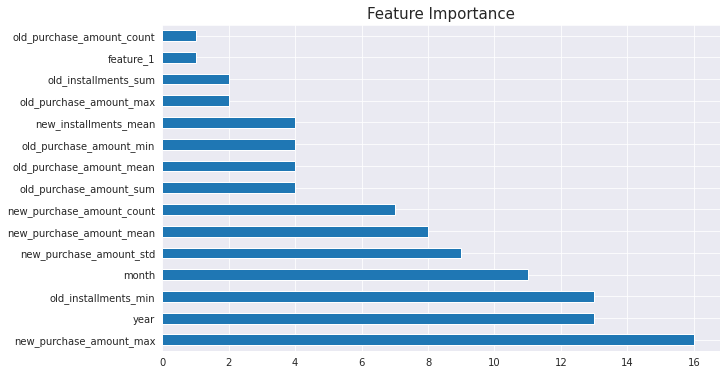

In [73]:
fig, ax = plt.subplots(figsize=(10,6))
feat_importances = pd.Series(model5.feature_importances_, index = x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('Feature Importance', fontsize = 15)
plt.show()

In [74]:
df = pd.DataFrame({'card_id': test['card_id'].values})
test_data_y = model5.predict(test_data_x)
df['target'] = test_data_y
df.to_csv(result_path + 'lgbm_regressor_test.csv', index=False)

<a name='section6.4.5'><a/>
### 6.4.5. AutoEncoder Model

Epoch 1/100
2367/2367 [==============================] - 6s 2ms/step - loss: 345.9576 - val_loss: 312.6183
Epoch 2/100
2367/2367 [==============================] - 5s 2ms/step - loss: 191.6252 - val_loss: 157.1668
Epoch 3/100
2367/2367 [==============================] - 5s 2ms/step - loss: 175.1770 - val_loss: 171.8894
Epoch 4/100
2367/2367 [==============================] - 5s 2ms/step - loss: 161.9315 - val_loss: 140.6840
Epoch 5/100
2367/2367 [==============================] - 5s 2ms/step - loss: 155.7208 - val_loss: 132.7171
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping


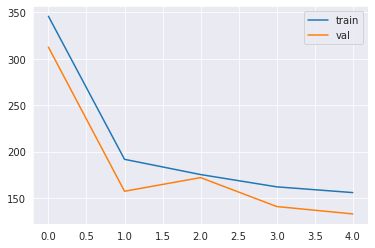

In [87]:
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true))) 

n_inputs = len(x_train.columns)

#scaler = StandardScaler()
#scaler.fit(x_train)
#x_train = scaler.transform(x_train)
#x_val = scaler.transform(x_val)

input = Input(shape=(n_inputs,))
encoded = Dense(16, activation='relu')(input)
encoded = BatchNormalization()(encoded)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(16, activation='relu')(decoded)
decoded = Dense(n_inputs, activation='linear')(decoded)

es = EarlyStopping(patience=4, verbose=1, min_delta=0.001, monitor='val_loss', mode='max', restore_best_weights=True)

autoencoder = Model(inputs=input, outputs=decoded)
autoencoder.compile(optimizer='adam', loss=root_mean_squared_error)
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=64, validation_data=(x_val, x_val), callbacks=[es])

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

encoder = Model(inputs=input, outputs=encoded)
encoder.save(model_path + 'encoder.h5')

In [88]:
encoder = load_model(model_path + 'encoder.h5', compile=False)
x_train_encode = encoder.predict(x_train)
x_val_encode = encoder.predict(x_val)

model7 = LGBMRegressor(n_jobs=-1, n_estimators = 100, max_depth = 1)
model7.fit(x_train_encode, y_train)

filename = model_path + 'auto_regressor.sav'
pickle.dump(model7, open(filename, 'wb'))

In [89]:
filename = model_path + 'auto_regressor.sav'
model7 = pickle.load(open(filename, 'rb'))

y_pred_train = model7.predict(x_train_encode)
y_pred_val = model7.predict(x_val_encode)

train_rmse = sqrt(mean_squared_error(y_train, y_pred_train))
val_rmse = sqrt(mean_squared_error(y_val, y_pred_val))

print("Train RMSE: {:2.5f}".format(train_rmse))
print("Val RMSE: {:2.5f}".format(val_rmse))

Train RMSE: 3.86696
Val RMSE: 3.78083


In [90]:
df = pd.DataFrame({'card_id': test['card_id'].values})
test_data_x_enc = encoder.predict(test_data_x)
test_data_y = model7.predict(test_data_x_enc)
df['target'] = test_data_y
df.to_csv(result_path + 'auto_regressor_test.csv', index=False)

<a name='section6.5'><a/>
## 6.5.Summary

In [96]:
x = PrettyTable(['Model', 'Train RMSE', 'Val RMSE'])
x.add_row(['Linear Regression', 3.8283, 3.8708])
x.add_row(['Support Vector Regressor', 3.8889, 3.8009])
x.add_row(['Random Forest Regressor', 3.5509, 3.7847])
x.add_row(['LGBM Regressor', 3.8227, 3.7970])
x.add_row(['AutoEncoder + LGBM Regressor', 3.8669, 3.7808])

print(x)

+------------------------------+------------+----------+
|            Model             | Train RMSE | Val RMSE |
+------------------------------+------------+----------+
|      Linear Regression       |   3.8283   |  3.8708  |
|   Support Vector Regressor   |   3.8889   |  3.8009  |
|   Random Forest Regressor    |   3.5509   |  3.7847  |
|        LGBM Regressor        |   3.8227   |  3.797   |
| AutoEncoder + LGBM Regressor |   3.8669   |  3.7808  |
+------------------------------+------------+----------+


<a name='section6.6'><a/>
## 6.6. Final Submission 

Kaggle Leader Board Score:

![kaggle-score-baseline](https://drive.google.com/uc?export=view&id=1-e11A54yCskfEK5SsxO8fne4vya9B4fI)



---



# References:

*   https://www.kaggle.com/c/elo-merchant-category-recommendation
*   https://stackoverflow.com/
*   https://seaborn.pydata.org/

